In [1]:
import re
import json
import tarfile
import pandas as pd
import seaborn as sns
from imdb import IMDb
from scipy import stats
import matplotlib.pyplot as plt

In [27]:
#Data preparation using only the CMU dataset as it is
path = 'MovieSummaries\\'
df_plot_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', names = ['WikipediaMovieID', 'PlotSummaries'], index_col = ['WikipediaMovieID'])
df_character = pd.read_csv("MovieSummaries/character.metadata.tsv", sep='\t', names = ['WikipediaMovieID', 'FreebaseMovieID', 'MovieReleaseDate', 'CharacterName', 
                                                                     'ActorDateOfBirth', 'ActorGender', 'ActorHeight', 'ActorEthnicity', 
                                                                     'ActorName', 'ActorAgeAtMovieRelease','FreebaseCharacter', 
                                                                     'FreebaseCharacterID', 'FreebaseActorID'], index_col = ['WikipediaMovieID'])
df_movies = pd.read_csv("MovieSummaries/movie.metadata.tsv", sep='\t', header = None, names = ['WikipediaMovieID', 'FreebaseMovieID', 'MovieName', 
                                                                                       'MovieReleaseDate', 'MovieBoxOfficeRevenue',
                                                                                       'MovieRuntime', 'MovieLanguages', 'MovieCountries',
                                                                                       'MovieGenres'], index_col = ['WikipediaMovieID'])


def get_first(mapping):
    mapping = json.loads(mapping)
    if mapping:
        return next(iter(mapping.values()))
    return None

def replace(text):
    return str(text).replace(" Language", "").replace(" language", "")

# Apply the function to get the first country name
df_movies['MovieCountries']= df_movies['MovieCountries'].apply(get_first)
df_movies['MovieLanguages']= df_movies['MovieLanguages'].apply(get_first)
df_movies['MovieLanguages']= df_movies['MovieLanguages'].apply(replace)
df_movies['MovieGenres']= df_movies['MovieGenres'].apply(get_first)
df_movies['MovieReleaseDate'] = pd.to_datetime(df_movies['MovieReleaseDate'], format='%Y-%m-%d', errors='coerce')


print(f'Size of df_movies = {len(df_movies)}')
print(f'Size of df_plot_summaries = {len(df_plot_summaries)}')
print(f'Size of df_character = {len(df_character)}')

Size of df_movies = 81741
Size of df_plot_summaries = 42303
Size of df_character = 450669


The percentage of missing data in MovieReleaseDate column =   51.83%
The percentage of missing data in MovieGenres column =   2.81%
The percentage of missing data in MovieBoxOfficeRevenue column =   89.72%


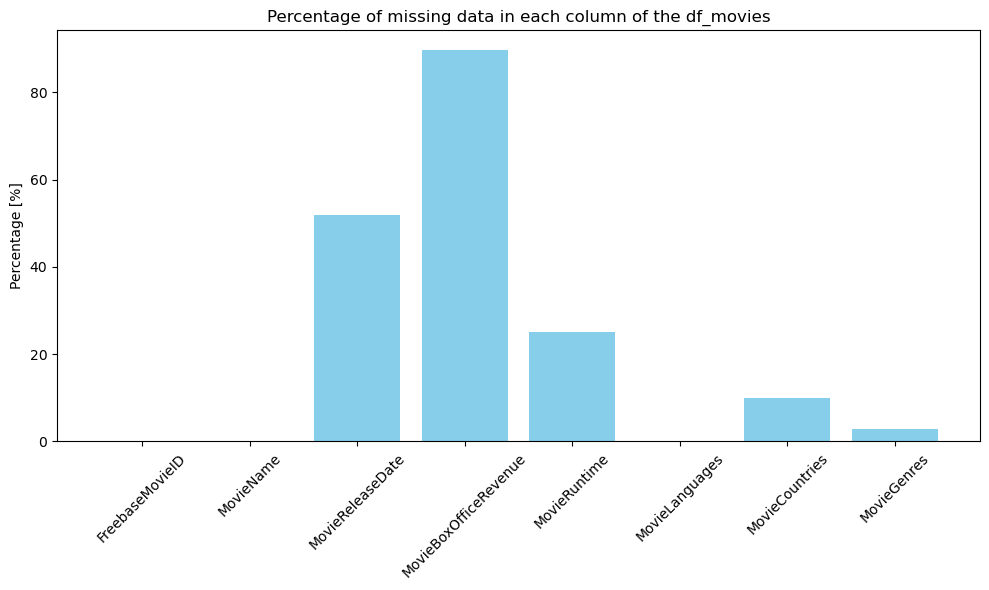

In [3]:
# Evaluate the percentage of missing data in relevant columns of df_movies
df_missing_data = (df_movies.isna().sum() / len(df_movies) ) * 100
missing_releaseDate_data = (df_movies.MovieReleaseDate.isna().sum() / len(df_movies) ) * 100
missing_genres_date = (df_movies.MovieGenres.isna().sum() / len(df_movies) ) * 100
missing_BOR_date = (df_movies.MovieBoxOfficeRevenue.isna().sum() / len(df_movies) ) * 100
print(f"The percentage of missing data in MovieReleaseDate column =  {missing_releaseDate_data: .2f}%")
print(f"The percentage of missing data in MovieGenres column =  {missing_genres_date: .2f}%")
print(f"The percentage of missing data in MovieBoxOfficeRevenue column =  {missing_BOR_date: .2f}%")
#
plt.figure(figsize=(10, 6))
plt.bar(df_missing_data.index, df_missing_data.values, color='skyblue')
plt.ylabel("Percentage [%]")
plt.title("Percentage of missing data in each column of the df_movies");
plt.xticks(rotation=45)
plt.tight_layout()

The percentage of missing data in MovieReleaseDate column of df_character =   12.23%


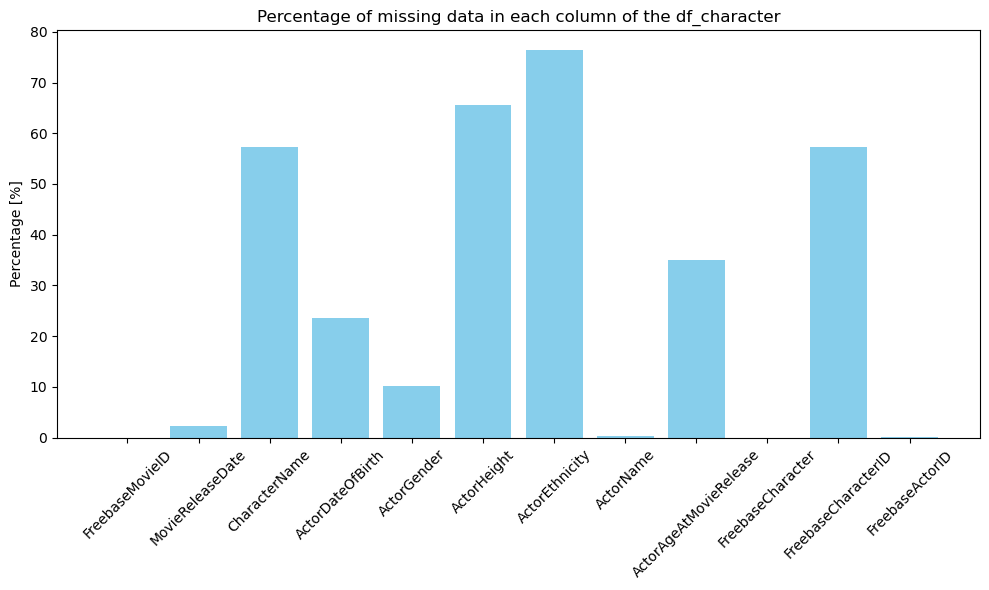

In [4]:
# Evaluate the percentage of missing data in relevant columns of df_characters
df_missing_character_data = (df_character.isna().sum() / len(df_character) ) * 100
missing_releaseDate_in_character_data = (df_character.MovieReleaseDate.isna().sum() / len(df_movies) ) * 100
print(f"The percentage of missing data in MovieReleaseDate column of df_character =  {missing_releaseDate_in_character_data: .2f}%")
plt.figure(figsize=(10, 6))
plt.bar(df_missing_character_data.index, df_missing_character_data.values, color='skyblue')
plt.ylabel("Percentage [%]")
plt.title("Percentage of missing data in each column of the df_character");
plt.xticks(rotation=45)
plt.tight_layout()

*******************************************************************************************************************************
#### We will merge the CMU dataframe with the IMDB non-commercial dataset (https://developer.imdb.com/non-commercial-datasets/) that includes ratings and other relevants informations about movies.
*******************************************************************************************************************************

In [17]:
# Load the merged dataset CMU + Kaggle
df_cmu = pd.read_csv("dataset/cmu_merged_with_imdb.csv")
pd.set_option('display.max_columns', None)

df_cmu = df_cmu[~df_cmu.PlotSummaries.isna()]
df_cmu = df_cmu[~df_cmu.MovieReleaseDate.isna()]
df_cmu = df_cmu[~df_cmu.genres.isna()]
df_cmu = df_cmu[~df_cmu.averageRating.isna()]
df_cmu

C:\Users\koami\AppData\Local\Temp\ipykernel_15956\856299667.py:2: DtypeWarning: Columns (1,5,6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cmu = pd.read_csv("dataset/cmu_merged_with_imdb.csv")


,IMDbID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,PlotSummaries,averageRating,genres
0,tt0228333,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","Set in the second half of the 22nd century, th...",4.9,"Action,Horror,Sci-Fi"
14,tt0097499,Henry V,1989.0,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,7.5,"Biography,Drama,History"
18,tt0058331,Mary Poppins,1964.0,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",The film opens with Mary Poppins perched in a...,7.8,"Comedy,Family,Fantasy"
30,tt0255819,Baby Boy,2001.0,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",A young 20-year-old named Jody lives with his...,6.4,"Crime,Drama,Romance"
31,tt0367546,Bindiya Chamkegi,1984.0,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",Shalini 'Shalu' lives a wealthy lifestyle with...,4.9,"Comedy,Family"
...,...,...,...,...,...,...,...,...,...,...
81941,tt0107057,Guilty as Sin,1993.0,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}",Jennifer Haines is an up-and-coming Chicago a...,5.7,"Crime,Drama,Thriller"
81943,tt0372937,Into the Mirror,2003.0,NaN,113.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea""}",After accidentally causing the death of his pa...,6.4,"Action,Fantasy,Horror"
81944,tt0109922,Gopi Kishan,1994.0,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",Kishan killed a man in his childhood when the...,5.8,"Action,Comedy,Drama"
81948,tt0033660,The Ghost Train,1941.0,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",{{plot}} The film opens with a Great Western e...,6.2,"Comedy,Horror"


***************************************************************************************************************
### Research question Q5 : How does the critical reception and recognition of movies with explicit socio-political content compare to those focused on entertainment or aesthetics?
***************************************************************************************************************

In [18]:
#******************************************************************************************************************************************
#Add a new column to the dataset to distinguish socio-political movies from the non-socio-political movies
#******************************************************************************************************************************************

# Here, we define keywords associated with socio-political themes
socio_political_keywords = ['politics', 'social justice', 'activism', 'protest', 'war', 'inequality']

# Function to categorize movies
def categorize_movie(row):
    # Check if any of the socio-political keywords appear in the plot summary
    plot_summary = row['PlotSummaries'].lower() if 'PlotSummaries' in row else ''
    
    for keyword in socio_political_keywords:
        if keyword in plot_summary:
            return 'Socio-Political'
    
    # Check if any of the socio-political keywords appear in the genres
    genres = row['Genre'].lower() if 'Genre' in row else ''
    genre_list = genres.split(',')  # Split the concatenated genres into a list
    
    for genre in genre_list:
        for keyword in socio_political_keywords:
            if keyword in genre:
                return 'Socio-Political'
    
    return 'Non Socio-Political'

# Create a new column 'Category' to store the categorization
df_cmu['Category'] = df_cmu.apply(categorize_movie, axis=1)

# Now, df contains a 'Category' column indicating whether a movie is socio-political or Non Socio-Political-focused

# The new updated dataset is saved to a new CSV file
output_path = 'cmu_merged_with_imdb.csv'
df_cmu.to_csv(output_path, index=False)

# Count the number of movies in each category
category_counts = df_cmu['Category'].value_counts()
print(category_counts)


display(df_cmu)

Category
Non Socio-Political    8442
Socio-Political        6508
Name: count, dtype: int64


,IMDbID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,PlotSummaries,averageRating,genres,Category
0,tt0228333,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","Set in the second half of the 22nd century, th...",4.9,"Action,Horror,Sci-Fi",Non Socio-Political
14,tt0097499,Henry V,1989.0,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,7.5,"Biography,Drama,History",Non Socio-Political
18,tt0058331,Mary Poppins,1964.0,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",The film opens with Mary Poppins perched in a...,7.8,"Comedy,Family,Fantasy",Socio-Political
30,tt0255819,Baby Boy,2001.0,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",A young 20-year-old named Jody lives with his...,6.4,"Crime,Drama,Romance",Socio-Political
31,tt0367546,Bindiya Chamkegi,1984.0,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",Shalini 'Shalu' lives a wealthy lifestyle with...,4.9,"Comedy,Family",Non Socio-Political
...,...,...,...,...,...,...,...,...,...,...,...
81941,tt0107057,Guilty as Sin,1993.0,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}",Jennifer Haines is an up-and-coming Chicago a...,5.7,"Crime,Drama,Thriller",Socio-Political
81943,tt0372937,Into the Mirror,2003.0,NaN,113.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea""}",After accidentally causing the death of his pa...,6.4,"Action,Fantasy,Horror",Non Socio-Political
81944,tt0109922,Gopi Kishan,1994.0,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",Kishan killed a man in his childhood when the...,5.8,"Action,Comedy,Drama",Socio-Political
81948,tt0033660,The Ghost Train,1941.0,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",{{plot}} The film opens with a Great Western e...,6.2,"Comedy,Horror",Socio-Political


Mean Ratings:
Category
Non Socio-Political    6.120137
Socio-Political        6.422895
Name: averageRating, dtype: float64

Median Ratings:
Category
Non Socio-Political    6.3
Socio-Political        6.5
Name: averageRating, dtype: float64
Frequency of Ratings in Socio-Political Category:
18       7.8
30       6.4
106      6.5
124      6.7
132      5.7
        ... 
81903    6.4
81939    8.2
81941    5.7
81944    5.8
81948    6.2
Name: averageRating, Length: 6508, dtype: float64

Frequency of Ratings in Non Socio-Politicals Category:
0        4.9
14       7.5
31       4.9
67       6.0
70       3.9
        ... 
81918    6.3
81921    5.1
81940    6.7
81943    6.4
81951    6.8
Name: averageRating, Length: 8442, dtype: float64


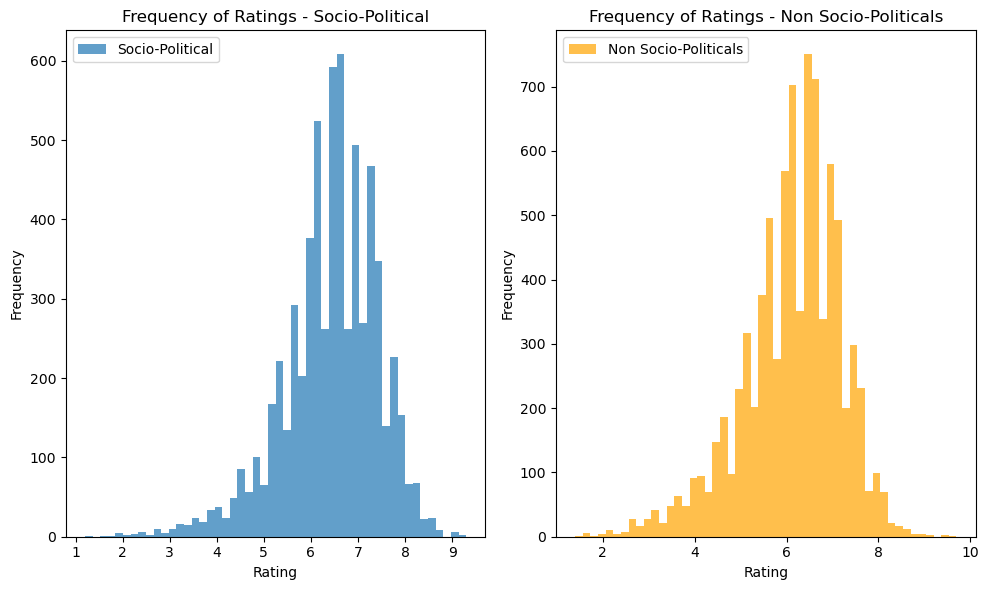

In [19]:
#*******************************************************************************************************************************************
#Ratings Analysis: Compare the average ratings of movies in both categories. Look at metrics like mean, median, and distribution of ratings.
#*******************************************************************************************************************************************
# Calculate the mean and median ratings for each category
mean_ratings = df_cmu.groupby('Category')['averageRating'].mean()
median_ratings = df_cmu.groupby('Category')['averageRating'].median()

print("Mean Ratings:")
print(mean_ratings)

print("\nMedian Ratings:")
print(median_ratings)

# Calculate frequency of each rating for 'Socio-Political' category
socio_political_frequency = df_cmu[df_cmu['Category'] == 'Socio-Political']['averageRating']

# Calculate frequency of each rating for 'Non Socio-Political' category
Non_Socio_Political_frequency = df_cmu[df_cmu['Category'] == 'Non Socio-Political']['averageRating']

print("Frequency of Ratings in Socio-Political Category:")
print(socio_political_frequency)

print("\nFrequency of Ratings in Non Socio-Politicals Category:")
print(Non_Socio_Political_frequency)

# Plotting histograms
plt.figure(figsize=(10, 6))
bins = 50
# Histogram for Socio-Political movies
plt.subplot(1, 2, 1)
plt.hist(socio_political_frequency, bins=bins, alpha=0.7, label='Socio-Political')
plt.title('Frequency of Ratings - Socio-Political')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

# Histogram for Non Socio-Politicals movies
plt.subplot(1, 2, 2)
plt.hist(Non_Socio_Political_frequency, bins=bins, alpha=0.7, color='orange', label='Non Socio-Politicals')
plt.title('Frequency of Ratings - Non Socio-Politicals')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

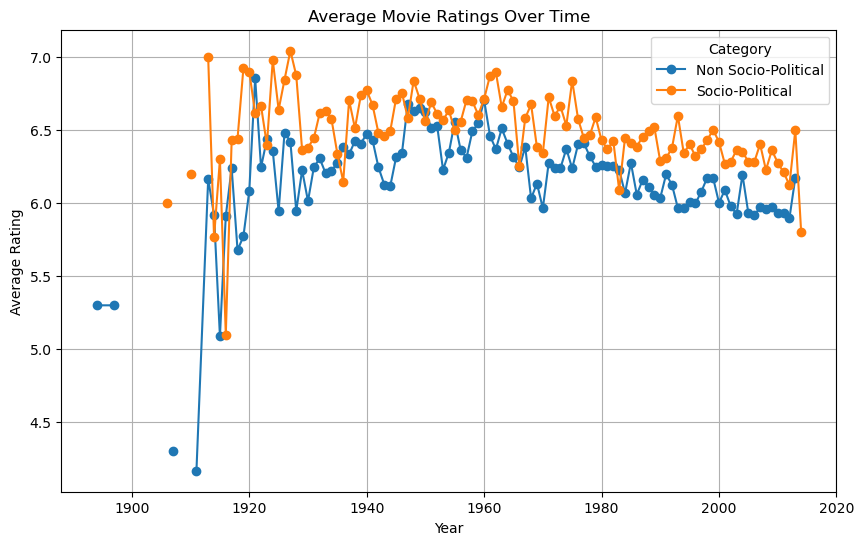

In [20]:
#*****************************************************************************************************************
#Trend Analysis Over Time: Analyze how the critical reception of movies in the Socio-political and Non Socio-Political categories has changed over time.
#*****************************************************************************************************************

# Group by ReleaseYear and Category, then calculate the mean rating for each group
mean_ratings_over_time = df_cmu.groupby(['MovieReleaseDate', 'Category'])['averageRating'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 6))
mean_ratings_over_time.plot(kind='line', marker='o', title='Average Movie Ratings Over Time', ylabel='Average Rating', xlabel='Year', grid=True, figsize=(10, 6))

plt.legend(title='Category')
plt.show()


In [39]:
#*****************************************************************************************************************************************************
#Statistical Tests:Conduct statistical tests (like t-tests or ANOVA) to see if there are significant differences in ratings between the two categories.
#*****************************************************************************************************************************************************

# Filter the ratings for each category
socio_political_ratings = df_cmu[df_cmu['Category'] == 'Socio-Political']['averageRating']
non_socio_political_ratings = df_cmu[df_cmu['Category'] == 'Non Socio-Political']['averageRating']

# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(socio_political_ratings, non_socio_political_ratings, nan_policy='omit')

print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Interpret the p-value
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant difference in ratings between the two categories.")
else:
    print("There is no significant difference in ratings between the two categories.")


T-Statistic: 17.43336048257116
P-Value: 2.1361098442919624e-67
There is a significant difference in ratings between the two categories.


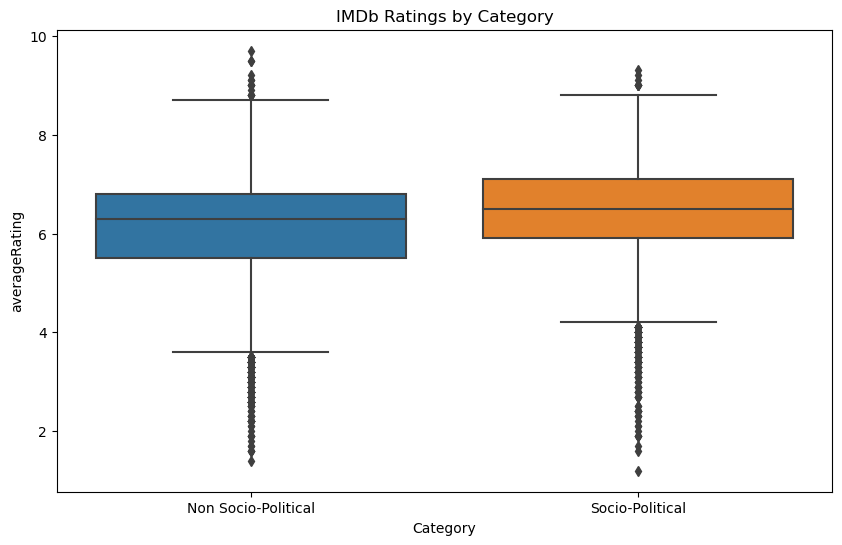

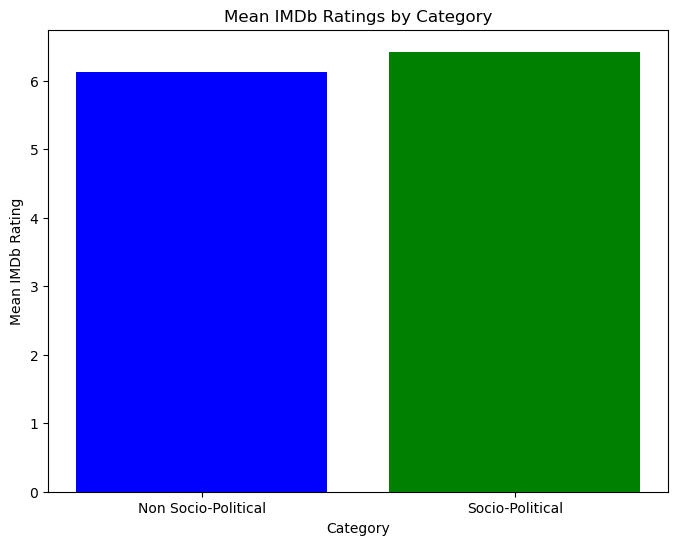

T-Statistic: 17.59321774338521
P-Value: 1.4422005814349149e-68
The difference in IMDb ratings is statistically significant.
Mean IMDb Rating (Socio-Political): 6.422894898586355
Mean IMDb Rating (Entertainment/Aesthetics): 6.12013740819711
Standard Deviation IMDb Rating (Socio-Political): 1.0103664816536573
Standard Deviation IMDb Rating (Non Socio-Political): 1.0843523423874841


In [23]:
#**********************************************************************************************************
#Create different plots to visualize the difference between the two categories
#**********************************************************************************************************

# Separate movies into two categories
socio_political_movies = df_cmu[df_cmu['Category'] == 'Socio-Political']
non_socio_political_movies = df_cmu[df_cmu['Category'] == 'Non Socio-Political']

# Create box plots to visualize IMDb ratings for each category
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='averageRating', data=df_cmu)
plt.title('IMDb Ratings by Category')
plt.show()

# Group the data by category and calculate the mean IMDb rating for each category
category_means = df_cmu.groupby('Category')['averageRating'].mean().reset_index()

# Create a bar chart to visualize mean IMDb ratings by category
plt.figure(figsize=(8, 6))
plt.bar(category_means['Category'], category_means['averageRating'], color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('Mean IMDb Rating')
plt.title('Mean IMDb Ratings by Category')
plt.xticks(rotation=0)
plt.show()

# Perform a t-test to compare IMDb ratings
t_statistic, p_value = stats.ttest_ind(socio_political_movies['averageRating'], non_socio_political_movies['averageRating'], equal_var=False)

# Print the results of the t-test
print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

# Determine if the difference is statistically significant
alpha = 0.05  # Set your significance level
if p_value < alpha:
    print('The difference in IMDb ratings is statistically significant.')
else:
    print('There is no statistically significant difference in IMDb ratings.')

# You can also calculate and print the means and standard deviations for each category
mean_socio_political = socio_political_movies['averageRating'].mean()
mean_non_socio_political = non_socio_political_movies['averageRating'].mean()
std_socio_political = socio_political_movies['averageRating'].std()
std_non_socio_political = non_socio_political_movies['averageRating'].std()

print(f'Mean IMDb Rating (Socio-Political): {mean_socio_political}')
print(f'Mean IMDb Rating (Entertainment/Aesthetics): {mean_non_socio_political}')
print(f'Standard Deviation IMDb Rating (Socio-Political): {std_socio_political}')
print(f'Standard Deviation IMDb Rating (Non Socio-Political): {std_non_socio_political}')


The statistical analysis provides strong evidence to conclude that movies with explicit socio-political content are received differently in terms of ratings when compared to movies focused on entertainment or aesthetics (non socio-political content). On average, movies with socio-political content tend to have slightly higher ratings than those in the entertainment/aesthetics category, and this difference is statistically significant. Additionally, the smaller standard deviation for Socio-Political movies suggests that they may also have more consistent ratings compared to Entertainment/Aesthetics movies.